# Comparing betting sites

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from azure.cosmos import CosmosClient
from azure.core.credentials import AzureKeyCredential
from IPython.display import display, clear_output
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json

In [2]:
with open('credenciales.json') as f:
   data = json.load(f)

### Getting scraped data from Azure Cosmos

You can do the same analysis using the CSV uploaded in the respository.

In [24]:
client_cosmos = CosmosClient(data['url'], credential=data['key'])
database_cosmos = client_cosmos.get_database_client(data['database'])
container = database_cosmos.get_container_client(data['container'])

query = '''
    SELECT c.fecha_hora_muestra, c.liga, c.evento, c.hora_muestra, c.fecha_muestra,
    c.hora_evento, c.fecha_evento, c.proveedor, c.odd_1, c.odd_x, c.odd_2
    FROM c 
    WHERE     
    c.liga = 'España / La Liga'  and 
    c.en_vivo="NO" AND 
    c.fecha_muestra>"2023-09-10"
    '''
print(query)

r = container.query_items(query=query,enable_cross_partition_query=True)
odds = pd.DataFrame(r)
odds.dropna(inplace = True)
odds.head()


    SELECT c.fecha_hora_muestra, c.liga, c.evento, c.hora_muestra, c.fecha_muestra,
    c.hora_evento, c.fecha_evento, c.proveedor, c.odd_1, c.odd_x, c.odd_2
    FROM c 
    WHERE     
    c.liga = 'España / La Liga'  and 
    c.en_vivo="NO" AND 
    c.fecha_muestra>"2023-09-10"
    


,fecha_hora_muestra,liga,evento,hora_muestra,fecha_muestra,hora_evento,fecha_evento,proveedor,odd_1,odd_x,odd_2
0,2023-09-11T00:00:03Z,España / La Liga,Rayo Vallecano - Alaves,00:00:03,2023-09-11,14:00,2023-09-15,Bet365,1.90,3.40,4.00
1,2023-09-11T00:00:03Z,España / La Liga,Athletic - Cadiz,00:00:03,2023-09-11,07:00,2023-09-16,Bet365,1.53,4.00,6.50
2,2023-09-11T00:00:03Z,España / La Liga,Valencia - Atletico Madrid,00:00:03,2023-09-11,09:15,2023-09-16,Bet365,3.80,3.30,2.00
3,2023-09-11T00:00:03Z,España / La Liga,Celta Vigo - Mallorca,00:00:03,2023-09-11,11:30,2023-09-16,Bet365,2.00,3.10,4.20
4,2023-09-11T00:00:03Z,España / La Liga,Barcelona - Betis,00:00:03,2023-09-11,14:00,2023-09-16,Bet365,1.40,4.75,7.00


Checking for incorrect DataTypes and correcting them

In [4]:
odds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44415 entries, 0 to 44414
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   fecha_hora_muestra  44415 non-null  object
 1   liga                44415 non-null  object
 2   evento              44415 non-null  object
 3   hora_muestra        44415 non-null  object
 4   fecha_muestra       44415 non-null  object
 5   hora_evento         44415 non-null  object
 6   fecha_evento        44415 non-null  object
 7   proveedor           44415 non-null  object
 8   odd_1               44415 non-null  object
 9   odd_x               44415 non-null  object
 10  odd_2               44415 non-null  object
dtypes: object(11)
memory usage: 3.7+ MB


In [5]:
odds["fecha_hora_muestra"]=odds["fecha_hora_muestra"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d %H"))
convert_dict = {'odd_1': float,
                'odd_x': float,
                'odd_2': float
                }
odds = odds.astype(convert_dict)
odds.head()

,fecha_hora_muestra,liga,evento,hora_muestra,fecha_muestra,hora_evento,fecha_evento,proveedor,odd_1,odd_x,odd_2
0,2023-09-11 00,España / La Liga,Rayo Vallecano - Alaves,00:00:03,2023-09-11,14:00,2023-09-15,Bet365,1.90,3.40,4.0
1,2023-09-11 00,España / La Liga,Athletic - Cadiz,00:00:03,2023-09-11,07:00,2023-09-16,Bet365,1.53,4.00,6.5
2,2023-09-11 00,España / La Liga,Valencia - Atletico Madrid,00:00:03,2023-09-11,09:15,2023-09-16,Bet365,3.80,3.30,2.0
3,2023-09-11 00,España / La Liga,Celta Vigo - Mallorca,00:00:03,2023-09-11,11:30,2023-09-16,Bet365,2.00,3.10,4.2
4,2023-09-11 00,España / La Liga,Barcelona - Betis,00:00:03,2023-09-11,14:00,2023-09-16,Bet365,1.40,4.75,7.0


Making all events have the same name, regardless of the Webpage the info came from:

In [6]:
def normalize(s):
    s = re.sub(' FC| AC| AFC| BSC| BK| CA| CD| CF| CP| CR| CS| CSD| FK| IA| PR|-PR| RCD| RC|-RJ| RJ| SA| SCO| SC|-SP| SP| SV| Balompie| del| de| SS| BC|Asociacion Deportiva |Deportivo|KV$|CC |Dep. |EM |FBC |Carlos A. |Carlos |Universidad| CF', '', s)
    s = re.sub('Rayo Vallecano', 'Rayo', s)
    s = re.sub('Atletico Madrid', 'Atletico', s)
    s = re.sub('Celta Vigo', 'Celta', s)
    s = re.sub('Betis Seville', 'Betis', s)
    s = re.sub('Real Sociedad San Sebastian', 'Real Sociedad', s)
    s = re.sub('Real Betis', 'Betis', s)
    s = re.sub('Athletic Bilbao', 'Athletic', s)
    return s


odds['evento']=odds['evento'].apply(normalize)

Only keeping events that have all 4 betting sites:

In [7]:
eventos_completos = odds.groupby(['evento'], as_index=False).agg(
                            cuenta_proveedor=pd.NamedAgg(column="proveedor", aggfunc="nunique"))

index_incomplete = eventos_completos[ (eventos_completos['cuenta_proveedor'] != 4) ].index
eventos_completos.drop(index_incomplete , inplace=True)
eventos_completos.reset_index(drop=True).head(15)

,evento,cuenta_proveedor
0,Alaves - Athletic,4
1,Almeria - Valencia,4
2,Athletic - Cadiz,4
3,Athletic - Getafe,4
4,Atletico - Real Madrid,4
5,Barcelona - Betis,4
6,Barcelona - Celta,4
7,Betis - Cadiz,4
8,Cadiz - Rayo,4
9,Celta - Alaves,4


In [8]:
odds = pd.merge(odds,eventos_completos[['evento']],on=['evento'], how = 'inner')

Calculating payout:

Payout is the percentage og the total amount of bets that are meant for paying prices.
The higher the payout the better for the user group.

In [9]:
odds["payout"]=1-((1/odds["odd_1"])+(1/odds["odd_x"])+(1/odds["odd_2"])-1)/((1/odds["odd_1"])+(1/odds["odd_x"])+(1/odds["odd_2"]))
odds.head(10)

,fecha_hora_muestra,liga,evento,hora_muestra,fecha_muestra,hora_evento,fecha_evento,proveedor,odd_1,odd_x,odd_2,payout
0,2023-09-11 00,España / La Liga,Rayo - Alaves,00:00:03,2023-09-11,14:00,2023-09-15,Bet365,1.9000,3.40,4.0,0.934201
1,2023-09-11 00,España / La Liga,Rayo - Alaves,00:00:30,2023-09-11,12:00:00,2023-09-15,BetCris,1.8475,3.30,5.1,0.961187
2,2023-09-11 00,España / La Liga,Rayo - Alaves,00:00:03,2023-09-11,14-00-00,2023-09-15,Codere,1.9500,3.25,4.1,0.939483
3,2023-09-11 00,España / La Liga,Rayo - Alaves,00:01:11,2023-09-11,14:00,2023-09-15,BetCha,1.9434,3.25,4.2,0.943085
4,2023-09-11 00,España / La Liga,Rayo - Alaves,00:30:03,2023-09-11,14:00,2023-09-15,Bet365,1.9000,3.40,4.0,0.934201
5,2023-09-11 00,España / La Liga,Rayo - Alaves,00:30:28,2023-09-11,12:00:00,2023-09-15,BetCris,1.8475,3.30,5.1,0.961187
6,2023-09-11 00,España / La Liga,Rayo - Alaves,00:30:03,2023-09-11,14-00-00,2023-09-15,Codere,1.9500,3.25,4.1,0.939483
7,2023-09-11 00,España / La Liga,Rayo - Alaves,00:31:10,2023-09-11,14:00,2023-09-15,BetCha,1.9434,3.25,4.2,0.943085
8,2023-09-11 01,España / La Liga,Rayo - Alaves,01:00:03,2023-09-11,14:00,2023-09-15,Bet365,1.9000,3.40,4.0,0.934201
9,2023-09-11 01,España / La Liga,Rayo - Alaves,01:00:35,2023-09-11,12:00:00,2023-09-15,BetCris,1.8475,3.30,5.1,0.961187


### Question: Which site posts events first?

In [10]:
first_sample = odds.groupby(['evento']).agg(
    fecha_hora_muestra=pd.NamedAgg(column="fecha_hora_muestra", aggfunc="min"))
first_sample.head(5)

,fecha_hora_muestra
evento,
Alaves - Athletic,2023-09-11 00
Almeria - Valencia,2023-09-11 00
Athletic - Cadiz,2023-09-11 00
Athletic - Getafe,2023-09-17 03
Atletico - Real Madrid,2023-09-11 00


In [11]:
primera_muestra = pd.merge(odds,first_sample,on=['evento', 'fecha_hora_muestra'])
primera_muestra.head(5)

,fecha_hora_muestra,liga,evento,hora_muestra,fecha_muestra,hora_evento,fecha_evento,proveedor,odd_1,odd_x,odd_2,payout
0,2023-09-11 00,España / La Liga,Rayo - Alaves,00:00:03,2023-09-11,14:00,2023-09-15,Bet365,1.9000,3.40,4.0,0.934201
1,2023-09-11 00,España / La Liga,Rayo - Alaves,00:00:30,2023-09-11,12:00:00,2023-09-15,BetCris,1.8475,3.30,5.1,0.961187
2,2023-09-11 00,España / La Liga,Rayo - Alaves,00:00:03,2023-09-11,14-00-00,2023-09-15,Codere,1.9500,3.25,4.1,0.939483
3,2023-09-11 00,España / La Liga,Rayo - Alaves,00:01:11,2023-09-11,14:00,2023-09-15,BetCha,1.9434,3.25,4.2,0.943085
4,2023-09-11 00,España / La Liga,Rayo - Alaves,00:30:03,2023-09-11,14:00,2023-09-15,Bet365,1.9000,3.40,4.0,0.934201


In [12]:
primera_muestra.groupby(['proveedor']).agg(
    cuenta=pd.NamedAgg(column="evento", aggfunc="nunique")).sort_values('cuenta', ascending=False)

,cuenta
proveedor,
Codere,30
BetCha,24
Bet365,23
BetCris,10


### Answer: 

Codere usualy post events first

## Question: Is there a lot of difference between the time events are shown on site?

In [13]:
first_sample_provider = odds.groupby(['evento','proveedor'], as_index=False).agg(
    fecha_hora_muestra=pd.NamedAgg(column="fecha_hora_muestra", aggfunc="min"))\
    .sort_values(['evento', 'fecha_hora_muestra'],ascending = [True, True])
first_sample_provider.head(5)

,evento,proveedor,fecha_hora_muestra
0,Alaves - Athletic,Bet365,2023-09-11 00
1,Alaves - Athletic,BetCha,2023-09-11 00
3,Alaves - Athletic,Codere,2023-09-11 00
2,Alaves - Athletic,BetCris,2023-09-16 18
4,Almeria - Valencia,Bet365,2023-09-11 00


In [14]:
a = pd.merge(first_sample_provider[first_sample_provider['proveedor']=='Codere']
             ,first_sample_provider,on='evento', how='outer')
index_duplicate = a[ (a['proveedor_x'] == a['proveedor_y']) ].index
a.drop(index_duplicate , inplace=True)
a["fecha_hora_muestra_x"] = a["fecha_hora_muestra_x"].apply\
                            (lambda x: datetime.strptime(x, "%Y-%m-%d %H"))
a["fecha_hora_muestra_y"] = a["fecha_hora_muestra_y"].apply\
                            (lambda x: datetime.strptime(x, "%Y-%m-%d %H"))
a['time_diff'] = (a["fecha_hora_muestra_y"] - a["fecha_hora_muestra_x"])/ pd.Timedelta(hours=1)
a.head(3)

,evento,proveedor_x,fecha_hora_muestra_x,proveedor_y,fecha_hora_muestra_y,time_diff
0,Alaves - Athletic,Codere,2023-09-11,Bet365,2023-09-11 00:00:00,0.0
1,Alaves - Athletic,Codere,2023-09-11,BetCha,2023-09-11 00:00:00,0.0
3,Alaves - Athletic,Codere,2023-09-11,BetCris,2023-09-16 18:00:00,138.0


In [15]:
a.groupby(['proveedor_y'], as_index=False).agg(
    time_diff=pd.NamedAgg(column="time_diff", aggfunc="mean"))

,proveedor_y,time_diff
0,Bet365,2.066667
1,BetCha,1.833333
2,BetCris,110.566667


### ANSWER:

Although, Codere almost everytime is the first one to upload events to bet on, 
Bet365 and Betcha upload their own approximately within the following 2 hours.
The same events would be seen in BetCris in the following few days.


## Who pays more?

In [16]:
max_cuotas = odds.groupby(['evento','proveedor'], as_index=False).agg(
                            odd_1=pd.NamedAgg(column="odd_1", aggfunc="max"),
                            odd_x=pd.NamedAgg(column="odd_x", aggfunc="max"),
                            odd_2=pd.NamedAgg(column="odd_2", aggfunc="max"))
max_cuotas.head(4)

,evento,proveedor,odd_1,odd_x,odd_2
0,Alaves - Athletic,Bet365,4.75,3.10,2.25
1,Alaves - Athletic,BetCha,4.50,3.20,2.25
2,Alaves - Athletic,BetCris,4.20,3.20,2.25
3,Alaves - Athletic,Codere,4.60,3.15,2.20


In [17]:
def get_cuota_minima_alta(df):
    if (df['odd_1']<df['odd_x']) and df['odd_1']<df['odd_2']:
        return df['odd_1']
    elif (df['odd_x']<df['odd_1']) and df['odd_x']<df['odd_2']:
        return df['odd_x']
    else:
        return df['odd_2']
def get_cuota_maxima_alta(df):
    if (df['odd_1']>df['odd_x']) and df['odd_1']>df['odd_2']:
        return df['odd_1']
    elif (df['odd_x']>df['odd_1']) and df['odd_x']>df['odd_2']:
        return df['odd_x']
    else:
        return df['odd_2']   

In [18]:
max_cuotas['cuota_menor']=max_cuotas.apply(get_cuota_minima_alta, axis =1)
max_cuotas['cuota_mayor']=max_cuotas.apply(get_cuota_maxima_alta, axis =1)
max_cuotas.drop(['odd_1', 'odd_x', 'odd_2'], axis=1, inplace = True)
max_cuotas.head(4)

,evento,proveedor,cuota_menor,cuota_mayor
0,Alaves - Athletic,Bet365,2.25,4.75
1,Alaves - Athletic,BetCha,2.25,4.50
2,Alaves - Athletic,BetCris,2.25,4.20
3,Alaves - Athletic,Codere,2.20,4.60


In [19]:
max_cuotas_reduced = max_cuotas.groupby(['evento']).agg(
                            cuota_menor=pd.NamedAgg(column="cuota_menor", aggfunc="max"),
                            cuota_mayor=pd.NamedAgg(column="cuota_mayor", aggfunc="max"))
max_cuotas_reduced.head(5)

,cuota_menor,cuota_mayor
evento,,
Alaves - Athletic,2.2500,4.75
Almeria - Valencia,2.6200,3.60
Athletic - Cadiz,1.6369,7.00
Athletic - Getafe,1.7692,6.75
Atletico - Real Madrid,2.8700,13.00


In [20]:
evento_seguro = pd.merge(max_cuotas[['evento', 'proveedor','cuota_menor']],
                         max_cuotas_reduced[['cuota_menor']],on=['evento', 'cuota_menor'])
cuenta_cuota_minima = evento_seguro.groupby(['proveedor']).agg(
                            cuenta_cuota_menor=pd.NamedAgg(column="evento", aggfunc="nunique"))\
                            .sort_values('cuenta_cuota_menor', ascending = False)
print('Higher paying low odds:')
cuenta_cuota_minima.head(20)

Higher paying low odds:


,cuenta_cuota_menor
proveedor,
BetCha,17
Bet365,12
BetCris,8
Codere,3


In [21]:
evento_seguro = pd.merge(max_cuotas[['evento', 'proveedor','cuota_mayor']],
                         max_cuotas_reduced[['cuota_mayor']],on=['evento', 'cuota_mayor'])
cuenta_cuota_mayor = evento_seguro.groupby(['proveedor']).agg(
                            cuenta_cuota_mayor=pd.NamedAgg(column="evento", aggfunc="nunique"))\
                            .sort_values('cuenta_cuota_mayor', ascending = False)
print('Higher paying high odds:')
cuenta_cuota_mayor.head(20)

Higher paying high odds:


,cuenta_cuota_mayor
proveedor,
Bet365,14
BetCha,14
BetCris,6
Codere,6


### ANSWER:

Betcha and Bet365 have the higher possible prices.
If you bet for the highly possible outcome, Betcha will mostlikely pay you more.
If you bet for the least possible outcome, Betcha or Bet365 will mostlikely pay you more.

### Interactable graph, you can change the event and the metric:

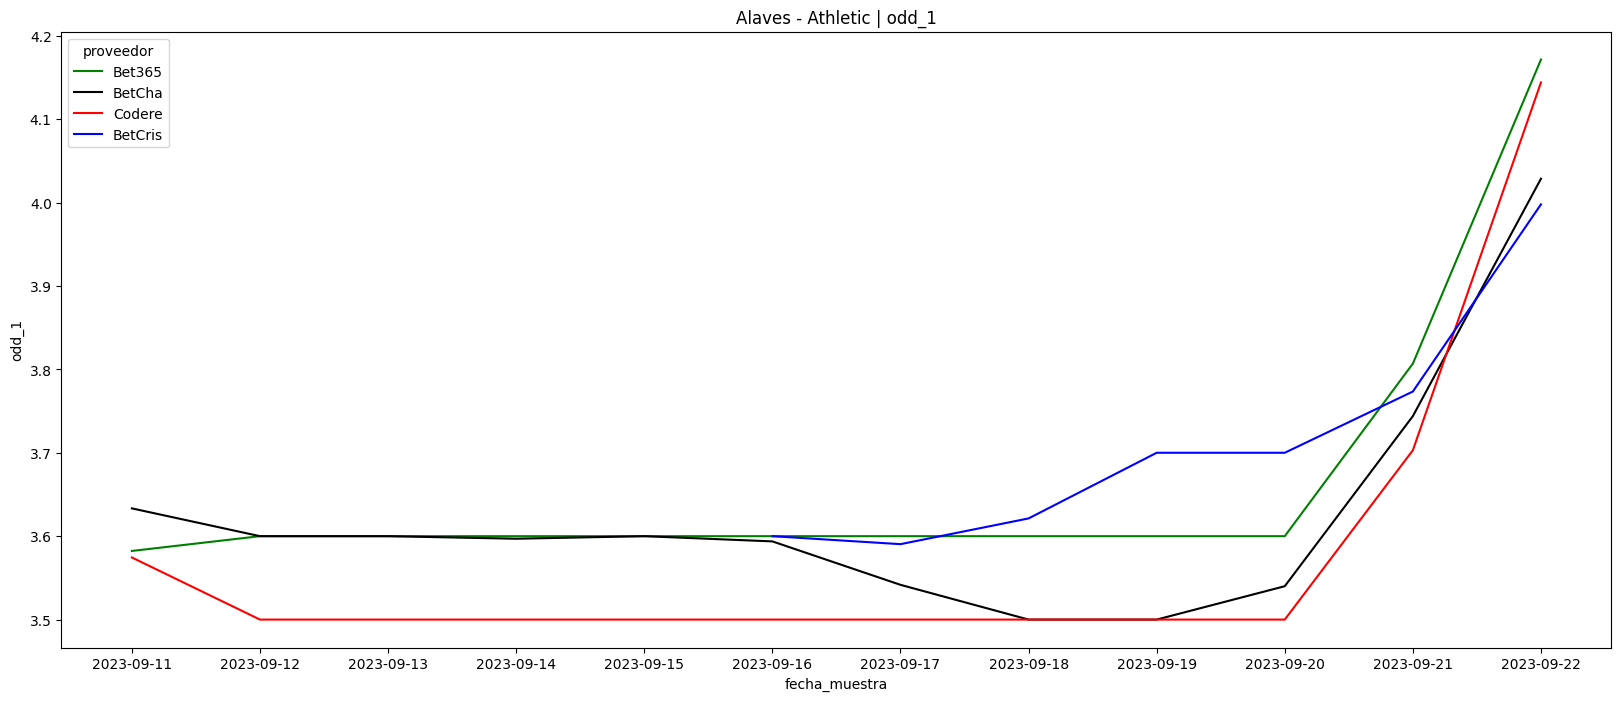

Dropdown(description='List', options=('Alaves - Athletic', 'Almeria - Valencia', 'Athletic - Cadiz', 'Athletic…

Dropdown(description='odds', options=('odd_1', 'odd_x', 'odd_2', 'payout'), value='odd_1')

In [22]:
odds2 = odds[['evento', 'proveedor','fecha_muestra','odd_1', 'odd_x', 'odd_2', 'payout']]
default_event = 'Alaves - Athletic'
default_odd = 'odd_1'
palette = {'Bet365': 'green',
          'BetCha': 'black',
          'BetCris': 'blue',
          'Codere': 'red'}
prueba = odds2.groupby(['evento','proveedor', "fecha_muestra"]).mean().sort_values(by='fecha_muestra', ascending=True).reset_index()
fig = plt.subplots(figsize=(20, 8))
sns.lineplot(x='fecha_muestra', y='odd_1', data=prueba[prueba['evento']==default_event],
             hue='proveedor', palette = palette).set(title='{} | {}'.format(default_event, default_odd))
plt.show()
mydata = np.unique(prueba['evento'])

w = widgets.Dropdown(
    options=mydata,
    value = default_event,
    description='List',
)
display(w)

odd = widgets.Dropdown(
    options=['odd_1', 'odd_x', 'odd_2', 'payout'],
    value2 = default_odd,
    description='odds',
)
display(odd)

def on_change(change):
    if (change['name'] == 'value') and (change['new'] != change['old']):
        default_event=change['new']
        clear_output()
        display(w)
        display(odd)
        fig = plt.subplots(figsize=(20, 8))
        sns.lineplot(data=prueba[prueba['evento']==default_event],x='fecha_muestra', y=default_odd,
                     hue='proveedor', palette= palette)\
        .set(title='{} | {}'.format(default_event, default_odd))
        plt.show()
def on_change_odd(change):
    if (change['name'] == 'value') and (change['new'] != change['old']):
        default_odd=change['new']
        clear_output()
        display(w)
        display(odd)
        fig = plt.subplots(figsize=(20, 8))
        sns.lineplot(data=prueba[prueba['evento']==default_event],x='fecha_muestra', y=default_odd,
                     hue='proveedor',palette=palette)\
        .set(title='{} | {}'.format(default_event, default_odd))
        plt.show()
w.observe(on_change)
odd.observe(on_change_odd)

## Conclusion:

Codere, Bet365 and BetCha are the fastest to upload events.
Bet365 and BetCha will pay you the most.
If i should pick one, I would select Bet365 as it's the most well known has no downside.
I would definitely give it a try to BetCha as they pay the most in the most possible scenarios.
